# Paul The Octopus

This notebook uses the [ramnquintana Football results dataset](https://www.kaggle.com/ramnquintana/resultados-de-futbol-entre-1872-y-2017).

## Goals

- Analize the historic football results between 1872 and 2017 for different championships and friendly games.
- Train with XGBoost to predict **local** and **away** scores depending on nominal values.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

import xgboost as xgb


sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Download [dataset](https://www.kaggle.com/ramnquintana/resultados-de-futbol-entre-1872-y-2017)

In [2]:
%%capture
import os

if not os.path.isdir('resultados-futbol'):
    os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
    !mkdir .kaggle
    !mv kaggle.json .kaggle
    !chmod 600 .kaggle/kaggle.json
    !kaggle datasets download -d ramnquintana/resultados-de-futbol-entre-1872-y-2017
    !mkdir resultados-futbol
    !unzip resultados-de-futbol-entre-1872-y-2017.zip -d resultados-futbol

## Data Visualization

The first goal is to understand the data that this dataset contains.

In [3]:
df = pd.read_csv('resultados-futbol/results.csv')
df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
21672,1998-11-18,Portugal,Israel,2,0,Friendly,Setúbal,Portugal,False
39735,2018-05-31,Barawa,Tamil Eelam,4,0,CONIFA World Football Cup,Bromley,England,False
31020,2009-02-01,Costa Rica,Panama,0,0,UNCAF Cup,Tegucigalpa,Honduras,True
14853,1988-03-26,Belgium,Hungary,3,0,Friendly,Brussels,Belgium,False
40442,2019-01-20,Jordan,Vietnam,1,1,AFC Asian Cup,Dubai,United Arab Emirates,True


In [4]:
# remove unused date
df = df.drop(['date'], axis=1)

As we can see, the dataset contains mostly nominal values (home_team, away_team, tournament, city, country), the ordinal values we are going to be analyzing are the **home** and **away** scores. These are the values we are trying to predict and it would be nice to understand their distribution and correlation.

We'll start by showing a boxplot to understand the general distribution and check for outliers.

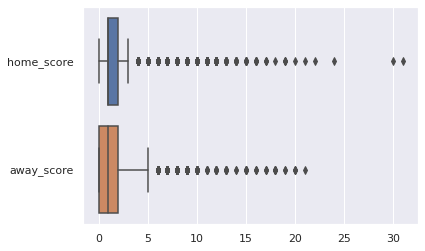

In [5]:
sns.boxplot(data=df.drop('neutral', axis=1), orient='h')

As can be seen, the **home score** tends to have higher values, while also having higher outliers. The **local score** tends to be lower but has more consistent values.

[None, None]

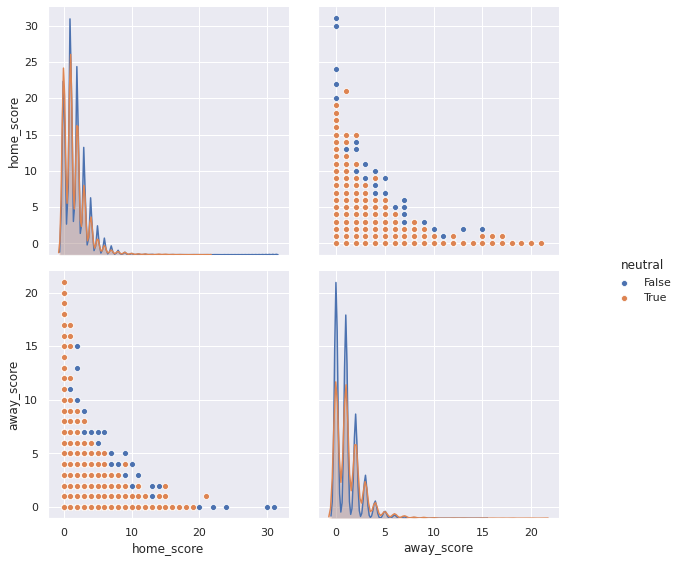

In [6]:
sns.pairplot(data=df, hue='neutral').fig.set(figwidth=10, figheight=8)

This pair plot allows us to understand the correlation between the scores and the **neutral** property. As can be seen in the these plots, the matches with higher **away scores** tend to be neutral, while the matches with higher **home score** tend to be less neutral.

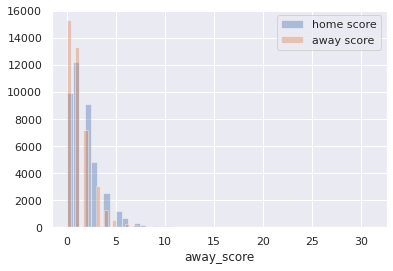

In [7]:
sns.distplot(df['home_score'], kde=False, label='home score')
sns.distplot(df['away_score'], kde=False, label='away score')
plt.legend()

To understand the distribution of the scores, depending on wether it is a **local** or **away** score, we can take a look at this plot. It can be easily seen that most of the matches had lower scores for the **away** team. There are more matches with higher scores for the **home** team.

## Prepare data to fit pipeline

As seen in the box-plot, our dataset contains many outliers for both the **local** and **away** scores. We need to remove these outliers before processing our dataset.

We'll use the Z Score (how many Standard Deviations we have between values) to remove these.

In [8]:
print(len(df))

df_oldf = df.copy()

df = df[((df.home_score - df.home_score.mean()) / df.home_score.std()).abs() < 3]
df = df[((df.away_score - df.away_score.mean()) / df.away_score.std()).abs() < 3]

print(len(df))

41243
39836


We can take a look into our boxplot to check the changes:

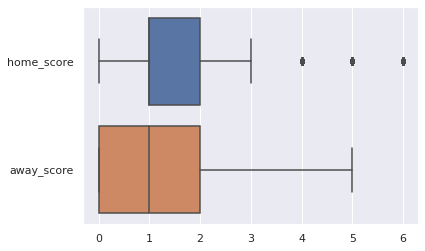

In [9]:
sns.boxplot(data=df.drop('neutral', axis=1), orient='h')

As mentioned before, our model needs to predict *scores*, an **ordinal value**, based on *teams, cities, tournaments* which are **nominal values**. The nominal values need to be encoded before being fed to our model, we'll use One Hot Encoding.

We'll start by converting our data to numpy, using the **X, y** format.

In [10]:
X = df[['home_team', 'away_team', 'tournament', 'city', 'neutral']].to_numpy()
y = df[['home_score', 'away_score']].to_numpy()

X.shape, y.shape

((39836, 5), (39836, 2))

Compare the first row of our ndarray with the first dataframe row.

In [11]:
X[0], y[0], df.loc[0]

(array(['Scotland', 'England', 'Friendly', 'Glasgow', False], dtype=object),
 array([0, 0]),
 home_team     Scotland
 away_team      England
 home_score           0
 away_score           0
 tournament    Friendly
 city           Glasgow
 country       Scotland
 neutral          False
 Name: 0, dtype: object)

## Regressor fit

We'll start by taking the unique values on the full dataset to feed the One Hot Encoding.

In [12]:
# create categories to fit the one hot encoder
team_category = np.unique(X[:, :2])
tournament_category = np.unique(X[:, 2])
city_category = np.unique(X[:, 3])
neutral_category = np.unique(X[:, 4])

categories = [
    team_category,
    team_category,
    tournament_category,
    city_category,
    neutral_category
]

X.shape, len(categories)

((39836, 5), 5)

Build our pipeline!

Our pipeline will consist of:

- An encoder for our features
- A Multi-Output regressor to predict the score results

In [13]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.23, random_state=46)
print(f'Training with: {X_train.shape[0]} values - Validating on {X_val.shape[0]} values')

# create pipeline
pipe = Pipeline([
    ('encoder', OneHotEncoder(categories=categories)),
    ('classifier', MultiOutputRegressor(xgb.XGBRegressor(seed=23, verbosity=0, silent=True, objective='reg:squarederror')))
])

Training with: 30673 values - Validating on 9163 values


We'll perform a Grid Search on our pipeline using different hyperparameters for our XGBRegressor:

In [14]:
%%capture

hyperparams = {
    'classifier__estimator__booster': ['gbtree', 'dart'],
    'classifier__estimator__gama': [0, 0.001],
    'classifier__estimator__learning_rate': [0.1, 0.01],
    'classifier__estimator__max_depth': [3, 5]
}

search = GridSearchCV(pipe, hyperparams, cv=10)
search.fit(X_train, y_train)

In [15]:
# which are the best params?
search.best_params_

{'classifier__estimator__booster': 'dart',
 'classifier__estimator__gama': 0,
 'classifier__estimator__learning_rate': 0.1,
 'classifier__estimator__max_depth': 5}

## Test and results visualization

We'll use the generated test-set to perform predictions, and we'll get some metrics from it:

In [16]:
# predict on the test-set

final = search
y_pred = final.predict(X_val)

Errors: Mean Squared Error and R2 Score:

In [17]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

mse, r2

(1.55515224033769, 0.0665657275486396)

Plot results and predicted to get an idea:

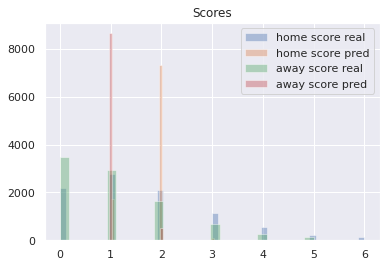

In [22]:
# plot relationship
plt.title('Scores')

sns.distplot(y_val[:, 0], kde=False, label='home score real')
sns.distplot(np.round(y_pred[:, 0]), kde=False, label='home score pred')

sns.distplot(y_val[:, 1], kde=False, label='away score real')
sns.distplot(np.round(y_pred[:, 1]), kde=False, label='away score pred')

plt.legend()
plt.show()